# Problem Set 5: Profit Diagram and Breakeven Points for a Short Strangle
A short strangle is an [advanced trading strategy](https://www.tastylive.com/concepts-strategies/strangle) that involves selling both a call and a put option on the same underlying stock. In this strategy, both options have the same expiration date but different strike prices. 

__Scenario:__ You are considering implementing a short strangle on Micron Technology, Inc. (MU) ahead of its upcoming earnings announcement scheduled for Wednesday, December 17, 2025 after market close. We downloaded the option chain data for MU options expiring on Friday, December 19, 2025 (41 days to expiration) from [Barchart](https://www.barchart.com/options) as of Friday, November 07, 2025. Using this data, you will analyze the profit and loss profile of the short strangle strategy, calculate breakeven points, and estimate the probability of profit using different share price distribution models.

Should we place the trade?

> __Learning Objectives:__
> 
> By the end of this problem set, you will be able to:
> * Build contract models for multi-leg options strategies using real market data and compute profit diagrams showing the payoff structure across a range of potential share prices at expiration.
> * Calculate analytical breakeven points for a short strangle and interpret the profit and loss regions on the profit diagram.
> * Apply cumulative distribution functions to estimate the probability of profit and various outcome scenarios using both geometric Brownian motion and implied volatility-based models for future share price distributions.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the metadata in the `metadata::Dict{String,Any}` variable and the options chain data in the `optionschain::DataFrame` variable.

In [2]:
metadata, optionschain = let
    
    # initialize -
    options_dataset = MyOptionsChainDataSet(ticker="mu");
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain) # return
end;

What's in the `metadata::Dict{String,Any}` dictionary?

In [3]:
let

    # initialize -
    df = DataFrame();
    fields = metadata |> keys |> collect |> sort;

    for i ∈ eachindex(fields)
        field = fields[i];
        row_df = (
            field = field |> String,
            value = metadata[field] |> string,
        );
        push!(df, row_df);
    end

    # make a table -
    pretty_table(
         df;
         fit_table_in_display_horizontally = false,
         backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );

end

 ---------------------------- --------------
                       field          value 
                      String         String 
 ---------------------------- --------------
                         DTE             41
                      atm_IV         0.7237
             expiration_date     2025-12-19
       historical_volatility         0.5930
                   is_weekly          false
               purchase_date     2025-11-07
                      source   barchart.com
  underlying_share_price_ask         239.10
  underlying_share_price_bid         239.02
  underlying_share_price_mid         237.02
 ---------------------------- --------------


__Note:__ The data was gathered after market close on November 7, 2025. The underlying stock is Micron Technology, Inc. (ticker symbol: MU). This stock experienced significant change after hours. The mid price reported in the dataset is the close price, while the bid/ask prices reflect after-hours trading. Options don't trade after hours, so we'll use the underlying close price for our analysis.

What about the `optionschain::DataFrame` variable?

In [4]:
optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,27.5,0.8844,208.6,210.15,211.7,179.0,0,"1,671",0.0,0.0,Call
2,30.0,0.8739,206.1,207.68,209.25,174.25,0,82,0.0,0.0,Call
3,32.5,0.8634,203.65,205.05,206.45,84.1,0,20,0.0,0.0,Call
4,35.0,0.8529,201.15,202.68,204.2,174.79,0,4,0.0,0.0,Call
5,37.5,0.8424,198.65,200.2,201.75,157.8,0,11,0.0,0.0,Call
6,40.0,0.8319,196.2,197.75,199.3,81.95,0,47,0.0,0.0,Call
7,42.5,0.8214,193.7,195.33,196.95,86.7,0,24,0.0,0.0,Call
8,45.0,0.8109,191.2,192.75,194.3,148.75,0,82,0.0,0.0,Call
9,47.5,0.8004,188.75,190.25,191.75,69.65,0,35,0.0,0.0,Call


In [5]:
let
        
        # initialize -
        δ = 0.5; # set the delta for ATM search
        options_chain = optionschain;
        Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x) # mid underlying price on purchase date, 11-07-2025

        # Next, let's find contracts that are at-the-money (ATM) or near-the-money (NTM) -
        atm_call_options = filter(row -> abs((row[:Strike] - Sₒ)/Sₒ) < δ, options_chain);
end

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,120.0,0.4956,117.1,118.4,119.7,111.05,27,"2,332",0.0,0.0,Call
2,125.0,0.4746,113.05,113.88,114.7,114.7,3,"2,264",1.1528,0.9691,Call
3,130.0,0.4536,107.35,108.53,109.7,106.0,3,"2,220",0.7114,0.996,Call
4,135.0,0.4326,102.5,103.63,104.75,101.44,2,"3,452",0.7325,0.9926,Call
5,140.0,0.4116,97.7,98.83,99.95,96.08,12,"3,311",0.7696,0.9859,Call
6,145.0,0.3906,92.9,94.3,95.7,87.36,4,"3,548",0.8379,0.9723,Call
7,150.0,0.3695,88.15,89.5,90.85,88.96,4,"3,215",0.7073,0.9811,Call
8,155.0,0.3485,83.4,84.85,86.3,75.38,4,"1,163",0.8191,0.9565,Call
9,160.0,0.3275,79.1,80.23,81.35,78.38,132,"2,284",0.8118,0.9461,Call


### Constants
Let's set a value for the step size `Δt::Float64`, i.e., `1 day` in units of years (assuming a `365-day` year), and the risk-free rate at the time we gathered the data for the option contracts; we approximate this value using the [yield on the 10-year Treasury Note](https://ycharts.com/indicators/10_year_treasury_rate). We also set a value for the underlying share price `Sₒ::Float64`, the number of levels in the binomial tree model `h::Int64`, the strike price `K::Float64`, and the direction parameter `θ::Int64`; we assume 11 levels per day.

In [6]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64, x) # mid underlying price on purchase date, 11-07-2025

237.02

Other constants:

In [7]:
Δt = (1/365); # options use 365 day year
DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
risk_free_rate = 0.0407; # yield 10-year treasury note on 07-Nov-2025
h = (DTE)*11 |> x-> floor(Int, x); # 11-points per trading day
θ = -1; # 1 = long strangle, -1 = short strangle
w = 0.5; # width of range to explore. Adjust me to see what happens

In this example, we'll need to project the future share price distribution at the contract's expiration date. We'll use a Geometric Brownian Motion (GBM) model to project the future share price distribution at expiration.

Let's load the single asset geometric Brownian motion (SAGBM) parameters which we estimated a few lectures ago, which include the drift and diffusion coefficients for each ticker. We'll store this data in the `parameters_df::DataFrame` variable:

In [8]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

We are looking at `MU`, so let's see what the parameters for this ticker are:

In [9]:
filter(:ticker=> x-> x=="MU", parameters_df)

Row,ticker,drift,t,lower_bound_drift,upper_bound_drift,volatility
,String7,Float64,Float64,Float64,Float64,Float64
1,MU,0.159132,1.96,0.156826,0.161439,0.406491


___

## Task 1: Select the strike prices for the call and put legs of the strangle
In this task, we'll select random put and call contracts (from which we construct our strangle) from the `MU` options chain data.
Let the put leg of the strangle have index `1`, and the call leg have index `2`. 

> __Setup__: For our __short strangle__, the put and call legs will bracket the initial share price, i.e., $K_{1}<S_{\circ}<K_{2}$, where $K_{1}$ is the strike price for the put leg, $K_{2}$ is the strike price for the call leg, and $S_{\circ}$ is the initial share price (price of the underlying asset when we initiate the position).

Let's select random strike prices for the put and call legs such that the $K_{1}<S_{\circ}<K_{2}$ inequality is satisfied.

Starting with the put contracts, filter the `dataset` to find the put contracts such that $\left(1-w\right)\cdot{S}_{\circ}\leq{K_{1}}<S_{\circ}$, where the $w>0$ value is specified above. This will give put contracts with strikes less than the initial share price but not too far from the money.

We'll use the [filter function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) in combination with the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Save the filtered selection of put contracts in the `put_contracts::DataFrame` variable:

In [10]:
put_contracts = let
    dataset = optionschain;
    contracts = filter(:Type=>x->x == "Put", dataset) |> y -> filter(:Strike=> x-> (x < Sₒ && x ≥ (1-w)*Sₒ), y)
    
    # Add error handling for empty contract lists
    if nrow(contracts) == 0
        error("No suitable put contracts found. Try increasing the 'w' parameter above to expand the search range.")
    end

    println("✓ Found $(nrow(contracts)) put contracts for the underlying in the range [$(round((1-w)*Sₒ, digits=2)), $(round(Sₒ, digits=2))]")
    contracts
end;

✓ Found 20 put contracts for the underlying in the range [118.51, 237.02]


In [11]:
put_contracts

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,120.0,-0.4956,0.4,0.55,0.7,0.56,17,"5,773",1.0501,-0.0165,Put
2,125.0,-0.4746,0.49,0.66,0.82,0.64,77,"3,274",1.0166,-0.0192,Put
3,130.0,-0.4536,0.54,0.75,0.96,0.7,27,"3,684",0.9767,-0.0216,Put
4,135.0,-0.4326,0.8,0.95,1.09,0.82,119,"1,476",0.9497,-0.0255,Put
5,140.0,-0.4116,0.75,1.11,1.47,0.98,100,"1,386",0.9274,-0.0304,Put
6,145.0,-0.3906,0.95,1.23,1.5,1.2,25,"2,861",0.9109,-0.0369,Put
7,150.0,-0.3695,1.15,1.44,1.73,1.35,27,"4,494",0.8798,-0.0422,Put
8,155.0,-0.3485,1.4,1.59,1.78,1.86,238,"3,227",0.8581,-0.0497,Put
9,160.0,-0.3275,1.74,1.93,2.12,2.07,95,"2,203",0.8583,-0.0622,Put


Select a random contract from the `put_contracts` collection; this will be our first leg of the strangle. Save the data for this contract in the `put_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [12]:
put_leg_data = let

    # select a random put contract (you can modify this to select based on other criteria)
    selected = nrow(put_contracts) |> i-> put_contracts[rand(1:i),:] # fancy!
    println("✓ Selected Put: Strike = $(selected[:Strike]), Premium = $(selected[:Mid]), IV = $(round(selected[:IV]*100, digits=1))%")
    selected
end

✓ Selected Put: Strike = 150.0, Premium = 1.44, IV = 88.0%


Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
7,150.0,-0.3695,1.15,1.44,1.73,1.35,27,"4,494",0.8798,-0.0422,Put


Next, do the same procedure for the call contracts. Filter `dataset` to find the call contracts with the property $S_{\circ}<K_{2}\leq\left(1+w\right)\cdot{S}_{\circ}$ where $w>0$ is specified above. To do this, we'll use the [filter function](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl) in combination with the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

Save the filtered selection of call contracts in the `call_contracts::DataFrame` variable:

In [13]:
call_contracts = let
    dataset = optionschain;
    contracts = filter(:Type=>x->x == "Call", dataset) |> y -> filter(:Strike=> x-> (x > Sₒ && x ≤ (1+w)*Sₒ), y)
    
    # Add error handling for empty contract lists
    if nrow(contracts) == 0
        error("No suitable call contracts found. Try increasing the 'w' parameter above to expand the search range.")
    end
    
    println("✓ Found $(nrow(contracts)) call contracts for the underlying in the range [$(round(Sₒ, digits=2)), $(round((1+w)*Sₒ, digits=2))]")
    contracts
end;

✓ Found 12 call contracts for the underlying in the range [237.02, 355.53]


In [14]:
call_contracts

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,240.0,-0.0087,22.3,22.6,22.9,22.45,776,"9,685",0.7225,0.5408,Call
2,250.0,-0.0508,18.0,18.48,18.95,18.32,"1,759","4,356",0.7214,0.4735,Call
3,260.0,-0.0928,14.5,15.03,15.55,14.76,"1,246","1,661",0.7185,0.4088,Call
4,270.0,-0.1348,11.95,12.25,12.55,11.95,458,"1,694",0.7215,0.3502,Call
5,280.0,-0.1769,9.35,9.68,10.0,9.75,"1,370","11,384",0.729,0.2991,Call
6,290.0,-0.2189,7.5,7.9,8.3,7.8,98,"2,822",0.7304,0.2518,Call
7,300.0,-0.2609,5.95,6.33,6.7,6.26,"1,089","8,283",0.734,0.2112,Call
8,310.0,-0.303,4.8,5.13,5.45,5.0,127,243,0.7369,0.176,Call
9,320.0,-0.345,3.9,4.15,4.4,4.25,143,"2,031",0.7541,0.1516,Call


Select a random contract from the `call_contracts::DataFrames` collection; this will be our second leg of the strangle. Save the data for this contract in the `call_leg_data` variable, which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [15]:
call_leg_data = let

    # select a random call contract (you can modify this to select based on other criteria)
    selected = nrow(call_contracts) |> i-> call_contracts[rand(1:i),:] # fancy!
    println("✓ Selected Call: Strike = $(selected[:Strike]), Premium = $(selected[:Mid]), IV = $(round(selected[:IV]*100, digits=1))%")
    selected
end

✓ Selected Call: Strike = 290.0, Premium = 7.9, IV = 73.0%


Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
6,290.0,-0.2189,7.5,7.9,8.3,7.8,98,"2,822",0.7304,0.2518,Call


__Quick Check__: Look at your selected strikes above. The put strike should be _below_ the current stock price, and the call strike should be _above_ it. The difference between them determines the __width of your strangle__.
___

## Task 2: Build contract models and compute the profit and breakeven values at expiration
In this task, let's compute the profit and breakeven values for our short strangle position constructed from the two random contracts selected in Task 1.
Now that we have data for the contracts, we can compute the composite contract profit and breakeven values for the short strangle constructed from the randomly selected put and call legs.

> __Strategy:__ First, [create `MyAmericanPutContractModel` and `MyAmericanCallContractModel` models](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#American-option-contracts), initialized using the data from the random contracts from Task 1. Then, these contract models and possible share prices at expiration are passed to [the `payoff(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.payoff), which computes the individual and composite payoff and profit values.

Start with the put contract model. Build a [`MyAmericanPutContractModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using the put contract data, and store this contract model in the `put_contract_model::MyAmericanPutContractModel` variable. 

To access data from the `DataFrameRow`, pass in the column name of what we want. For example, to get the strike price, you would say: `put_leg_data[:Strike]`. For the premium value, use the midpoint value.

In [16]:
put_contract_model = build(MyAmericanPutContractModel, (
        K = put_leg_data[:Strike], # TODO: set the strike price
        premium = put_leg_data[:Mid], # TODO: set the premium value
        IV = put_leg_data[:IV], # TODO: set the IV
        DTE = DTE*(Δt), # TODO: set the DTE (units: years)
        sense = θ, # we are short, i.e., we *sold* this contract so sense = -1 
        copy = 1
));

Similarly, construct the call contract model. Save the call contract model in the `call_contract_model::MyAmericanCallContractModel` variable:

In [17]:
call_contract_model = build(MyAmericanCallContractModel, (
        K = call_leg_data[:Strike], # TODO: set the strike price
        premium = call_leg_data[:Mid], # TODO: set the premium value
        IV = call_leg_data[:IV], # TODO: set the IV
        DTE = DTE*(Δt), # TODO: set the DTE (units: years)
        sense = θ, # we are short, i.e., we *sold* this contract so sense = -1 
        copy = 1
));

Next, create an array of values for the share price at expiration. We'll look at a range starting from below $K_{1}$ and ending above $K_{2}$ with `number_of_steps` values. Store these values in the `share_price_array::Array{Float64,1}` variable.

In [18]:
future_share_price_array = let

    # initialize -
    number_of_steps = 1001; # leave me alone!

    # build a range, then pass that to collect (which gives an array)
    share_price_array = range((1-w)*put_contract_model.K,stop = (1+w)*call_contract_model.K, length = number_of_steps) |> collect;

    # return the data
    share_price_array;
end;

Finally, compute the profit for the short strangle. We compute the profit by [calling the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) and save the profit values in the `profit_array` variable. The [`profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit) takes two arguments: the contract models as an array and the share price array.

The `profit_array` will be a `1001`$\times$ `4` array, in which each row is a possible value for the share price at expiration $S_{T}$. Column `1` holds the possible $S_{T}$ values, column `2` holds the profit for the short `put`, column `3` holds the profit for the short `call`, and column `4` holds the overall profit for the composite trade.

In [19]:
profit_array = profit([put_contract_model, call_contract_model], future_share_price_array);

`Unhide` the code below to see how we visualized the profit and breakeven points for the short strangle.

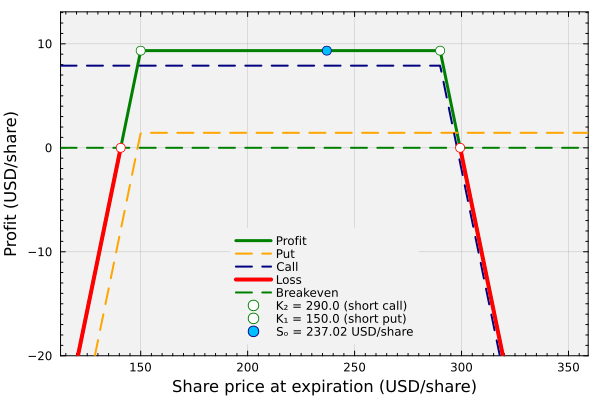

In [20]:
let
    
    # initialize -
    K₁ = put_leg_data[:Strike]; # get strike of the put leg
    K₂ = call_leg_data[:Strike]; # get strike of the call leg
    premium_1 = put_leg_data[:Mid] # get premium of the put leg
    premium_2 = call_leg_data[:Mid] # get premium of the call leg
    max_profit = (premium_1 + premium_2); # max profit is the total premium collected
    S = future_share_price_array
    number_of_steps = length(S);
    BEL = zeros(length(S))

    # Which are profit points?
    profit_idx = findall(>(0), profit_array[:,4])
    loss_array = profit_array[:,:]; loss_array[profit_idx,:] .= NaN
    
    # Calculate breakeven points
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K₂ + (premium_1 + premium_2);
    breakeven_array[2,1] = K₁ - (premium_1 + premium_2);


     plot(profit_array[:,1], profit_array[:,4], lw=3, label="Profit", c=:green, 
        bg="gray95", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:bottom, 
        xminorticks=10, yminorticks=10, xlim=(0.8*breakeven_array[2,1],1.2*breakeven_array[1,1]), ylim=(-20,max_profit*1.4))
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put", ls=:dash, c=:orange)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call", ls=:dash, c=:navyblue)
    plot!(loss_array[:,1], loss_array[:,4], lw=4, label="Loss", c=:red)
    
    plot!(S,BEL,lw=2, c=:green, label="Breakeven", ls=:dash)
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:white, msc=:red,label="", ms=5)
    
    scatter!([K₂],[max_profit], ms=5, label = "K₂ = $(K₂) (short call)", msc=:green, c=:white)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short put)", msc=:green, c=:white)

    
    # VLINE[1] = Sₒ
    # VLINE[2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    scatter!([Sₒ], [max_profit], ms=5, c=:deepskyblue1, msc=:navy, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)

    # uncomment line below to save figure to disk
    # savefig("Fig-ShortStrangle-PS5-Fall-2024.svg")
end

In [21]:
do_I_see_the_profit_loss_plot = true; # set this value {true | false}

### Breakeven and Delta Analysis
Compute the breakeven points for the short `MU` strangle. Save these values in the `B_low::Float64` and `B_high::Float64` variables. A strangle has two possible breakeven points at expiration denoted as $B^{+}$ and $B^{-}$:
$$
\begin{equation}
	B(T) = \begin{cases}
		B^{-} = K_{1} - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right) & S_{T} < K_{1} \\
		B^{+} = K_{2} + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right) & S_{T} > K_{2}
	\end{cases}
\end{equation}
$$
where $S_{T}$ denotes the share price at expiration, $B^{+}$ denotes the upper breakeven point, $B^{-}$ denotes the lower breakeven point, index $1$ denotes the $\texttt{put}$ contract, index $2$ denotes the $\texttt{call}$ contract; for a strangle $K_{1}<K_{2}$. 

In [22]:
B_low, B_high = let

    # initialize -
    B_low = nothing;
    B_high = nothing;

    # Low - put side
    K₁ = put_contract_model.K;
    P₁ = put_contract_model.premium;

    # High - call side
    K₂ = call_contract_model.K;
    P₂ = call_contract_model.premium;

    # compute -
    B_low = K₁ - (P₁ + P₂);
    B_high = K₂ + (P₁ + P₂);

    # return -
    B_low, B_high
end;

Next, let's compute the $\Delta$ of each contract and compare our computation to what is reported in the dataset. Let's start with the put contract. Save this value in the $\Delta_{1}$`::Float64` variable.

In [23]:
Δ₁ = let

    # initialize
    greek_value = 0.0; # initially set the greek value to 0
    contract_model = deepcopy(put_contract_model); # alias the contract model
    contract_model.sense = 1; # set to long position for greek calculation (then correct later)

    # call the greek function
    greek_value = delta(contract_model, h = h,  T = contract_model.DTE, 
        σ = contract_model.IV, Sₒ = Sₒ, μ = risk_free_rate);

    # return -
    greek_value;
end

-0.039999999999999813

Next, let's compute the $\Delta$ value for the call contract. Save this value in the $\Delta_{2}$`::Float64` variable.

In [24]:
Δ₂ = let
    
    # initialize
    greek_value = 0.0; # initially set the greek value to 0
    contract_model = deepcopy(call_contract_model); # alias the contract model
    contract_model.sense = 1; # set to long position for greek calculation (then correct later)

    # call the greek function
    greek_value = delta(contract_model, h = h,  T = contract_model.DTE, 
        σ = contract_model.IV, Sₒ = Sₒ, μ = risk_free_rate);

    # return -
    greek_value;
end

0.2400000000000002

Finally, let's put all this together into a table, and see what we can see.

> __Summary__: The table below summarizes key metrics for the short strangle position. Columns `BEL` and `BEH` show the lower and upper breakeven points $B^{-}$ and $B^{+}$ (USD/share), while `max_profit` displays the total premium collected (USD/share). Column `width` represents the strangle width $K_{2} - K_{1}$ (USD/share). Columns `Δ₁`, `Δ₂`, and `Δₚ` show the computed delta values for the put, call, and portfolio $\Delta_{p} = \theta\cdot(\Delta_{1} + \Delta_{2})$ using our binomial tree model. Finally, `delta_put`, `delta_call`, and `obs_delta` display the market data delta values and the observed portfolio delta for comparison.

So what do we see in the table below?

In [25]:
let
    # initialize -
    df = DataFrame();

    # get/compute the data -
    total_premium = put_contract_model.premium + call_contract_model.premium
    strangle_width = call_contract_model.K - put_contract_model.K
    delta_put_data = put_leg_data[:Delta];
    delta_call_data = call_leg_data[:Delta];

    # package data -
    row_df = (
        BEL = round(B_low, digits=2),
        BEH = round(B_high, digits=2),
        max_profit = round(total_premium, digits=2),
        width = round(strangle_width, digits=2),
        Δ₁ = Δ₁,
        Δ₂ = Δ₂,
        Δₚ = θ*(Δ₁ + Δ₂),
        delta_put = delta_put_data,
        delta_call = delta_call_data,
        obs_delta = -1*(delta_put_data + delta_call_data)
    );
    push!(df, row_df);

    # make a table -
    pretty_table(
            df;
            fit_table_in_display_horizontally = false,
            backend = :text,
            table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 --------- --------- ------------ --------- --------- --------- --------- ----------- ------------ -----------
      BEL       BEH   max_profit     width        Δ₁        Δ₂        Δₚ   delta_put   delta_call   obs_delta 
  Float64   Float64      Float64   Float64   Float64   Float64   Float64     Float64      Float64     Float64 
 --------- --------- ------------ --------- --------- --------- --------- ----------- ------------ -----------
   140.66    299.34         9.34     140.0     -0.04      0.24      -0.2     -0.0422       0.2518     -0.2096
 --------- --------- ------------ --------- --------- --------- --------- ----------- ------------ -----------


___

## Task 3: Compute the probability of profit for the random short strangle
In this task, we'll compute the likelihood of various profit levels for the random short-strangle position. To do this, we'll construct models that predict the underlying asset's share price to the contracts' expiration and then use the cumulative distribution function to compute the probability of various conditions being true. 

Let's start by building two models we use to estimate future share price: __Model 1__: geometric Brownian motion (GBM) and __Model 2__: Implied Volatility models.

### Model 1: Geometric Brownian Motion
Build an instance of the [MyGeometricBrownianMotionEquityModel type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) which holds values for the drift `μ` and volatility `σ` parameters using a [custom build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). 
* We set the drift parameter to the risk-free rate $\mu = \bar{r}$ (because options use a risk-neutral probability measure), and the volatility is set to the implied volatility estimate $\sigma = \text{IV}$ from the options chain data.
* __Hmmm__. But we have two contracts? Let's use the average `IV` value for two contracts. Alternatively, we could use the at-the-money (ATM) implied volatility, which is `72.37%` for Micron.

Save the GBM model in the `gbm_model::MyGeometricBrownianMotionEquityModel` variable:

In [26]:
gbm_model, σ̄ = let

    # Step 1: compute the average implied volatility σ̄:
    σ̄ = (1/2)*(call_leg_data[:IV] + put_leg_data[:IV]);
    historical_volatility = filter(:ticker=> x-> x=="MU", parameters_df)[!,:volatility][1]
    historical_drift = filter(:ticker=> x-> x=="MU", parameters_df)[!,:drift][1]
    barchart_vol_value = metadata["historical_volatility"] |> x-> parse(Float64,x);
    atm_IV = metadata["atm_IV"] |> x-> parse(Float64,x);
    
    # Display intermediate results
    println("Implied Volatility estimate:")
    println("   Put IV: $(round(put_leg_data[:IV]*100, digits=1))%")
    println("   Call IV: $(round(call_leg_data[:IV]*100, digits=1))%") 
    println("   Average σ̄: $(round(σ̄*100, digits=1))%")
    println("   Historical volatility (our estimate 2014 - 2024 data): $(round(historical_volatility*100, digits=1))%")
    println("   Barchart historical value: $(round(barchart_vol_value*100, digits=1))%")
    println("   atm_TV: $(round(atm_IV*100, digits=1))%")

    # Step 2: build the GBM model
    model = build(MyGeometricBrownianMotionEquityModel, (
        μ = risk_free_rate,
        σ = σ̄
    ));
    
    println("✓ GBM model created with μ = $(round(model.μ*100, digits=2))% and σ = $(round(model.σ*100, digits=1))%")

    model, σ̄
end;

Implied Volatility estimate:
   Put IV: 88.0%
   Call IV: 73.0%
   Average σ̄: 80.5%
   Historical volatility (our estimate 2014 - 2024 data): 40.6%
   Barchart historical value: 59.3%
   atm_TV: 72.4%
✓ GBM model created with μ = 4.07% and σ = 80.5%


Now that we have a populated [MyGeometricBrownianMotionEquityModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) holding the `MU` data, let's generate `number_of_samples` possible future share price values using the [sample(...) function exported by the VLQuantitativeFinancePackage.jl package](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}).
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) takes a `model::MyGeometricBrownianMotionEquityModel` instance as the first argument, along with the time values that we wish to sample: `T₁::Float64` is the start time, `T₂::Float64` is the stop time (in units of `years`), `Δt::Float64` is the time step (in units of `years`), and `Sₒ::Float64` denotes the initial share price (in units of `USD/share`). Finally, we pass in the number of samples we want to generate in the `number_of_paths` argument.
* The [sample method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyMultipleAssetGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_paths` sample paths from $T_{1}\rightarrow{T}_{2}$ in steps of $\Delta{t}$. However, we only want the share prices corresponding to the duration of the contract, i.e., $T_{2} = \text{DTE}$. Thus, we pass the full `samples` array [using the Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to a slicing operation where we select columns `2:end` of the last row (column 1 holds the time). We store the `number_of_paths` samples of the share price at $T_{2}$ in the `endpoint_samples::Array{Float64,1}` variable.

So what do we get?

In [27]:
endpoint_samples = let
    number_of_samples = 10000; # You can change this!
    endpoint = VLQuantitativeFinancePackage.sample(gbm_model, (
        T₁ = 0.0,
        T₂ = (DTE)*(Δt),
        Δt = Δt,
        Sₒ = Sₒ
    ), number_of_paths = number_of_samples) |> samples -> samples[end,2:end]; # get last row from col 2 -> number_of_paths

    endpoint;
end;

We've previously shown that sampling a GBM model emits a LogNormal share price distribution. Fit a [LogNormal distribution exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.LogNormal) using the [fit_mle(...) function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}), and save this in the `d_gbm` variable:

In [28]:
d_gbm = fit_mle(LogNormal, endpoint_samples);

`Unhide` the code block below to see how we plotted the future share price of `MU` generated using a risk-neutral single-asset geometric Brownian motion model parameterized using implied volatility.
> __What do we see?__ The geometric Brownian motion generates future share prices that are [log-normally distributed](https://en.wikipedia.org/wiki/Log-normal_distribution) (blue line) (confirmed by the check above). The [maximum-likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) of the distribution produces a model that describes the simulated endpoint sample share prices (red line).

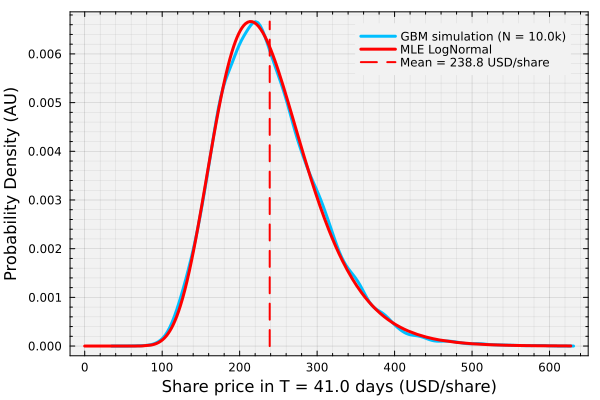

In [29]:
let

    # setup the mean line (for plotting) -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    LX = ones(100) .* mean(d_gbm);
    LY = range(0, stop = maximum(pdf.(d_gbm, range(quantile(d_gbm,0.01), stop=quantile(d_gbm,0.99), length=100))), length = 100) |> collect;

    # plot -
    density(endpoint_samples, lw=3, c=:deepskyblue1, label="GBM simulation (N = $(length(endpoint_samples)/1000)k)")
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, xminorticks=true, xminorgrid = true, yminorgrid = true)
    
    plot!(LX, LY, lw=2, ls=:dash, c=:red, label="Mean = $(round(mean(d_gbm),digits=2)) USD/share")
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

### Model 2: Future share price projection using the Implied Volatility
Alternatively, we could use the implied volatility to estimate the expected share price move over some time $0\rightarrow{T}$.
Suppose we construct a [Normal distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) $\mathcal{N}(\mu_{IV},\sigma_{IV})$ where the mean $\mu_{IV} = S_{\circ}\exp(\bar{r}\cdot{T\Delta{t}})$, i.e., the risk-neutral future value of the current share price, or just $\mu_{IV}\approx{S}_{\circ}$ for short-duration contracts, and the standard deviation $\sigma_{IV}$ is:
$$
\sigma_{IV} = S_{\circ}\cdot\left(\frac{\text{IV}}{100}\right)\cdot\sqrt{\text{T}\cdot\Delta{t}}
$$
using the [Normal type exported by the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal). 
 > __Note:__ In the expression above, the `IV` is given as a percentage `X.Y%`. If we already have a decimal, then do __not__ divide by `100`.

This is only an approximate model of the future share price. However, this model is widely used to generate quick estimates of future share price ranges using the forward-looking implied volatility `IV`. Let's save the Normal IV distribution $\mathcal{N}(\mu_{IV},\sigma_{IV})$ in the `d_IV` variable (don't forget to use $\bar{\sigma}$ for the implied volatility, as a decimal):

In [30]:
d_IV = Normal(Sₒ*exp(risk_free_rate*DTE*Δt), Sₒ*(σ̄)*sqrt(DTE*Δt));

`Unhide` the code block below to see how we plotted the `d_gbm::LogNormal` and `d_IV::Normal` future share price densities at the contract's expiration date.

> __What do we see?__ The log-normal GBM share price distribution (blue line) is right-skewed and cannot admit negative share prices. However, the Normal IV distribution (red line) is symmetric around the future share price and can admit negative share prices, albeit with a small probability.

How do the two distributions compare?

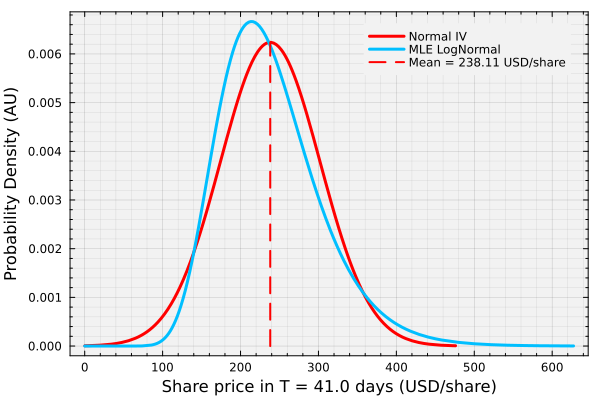

In [31]:
let

    # initialize -
    DTE = metadata["DTE"] |> x-> parse(Float64, x); # days to expiration (units: days)
    LX = ones(100) .* mean(d_IV);
    LY = range(0, stop = maximum(pdf.(d_IV, range(quantile(d_IV,0.01), stop=quantile(d_IV,0.99), length=100))), length = 100) |> collect;

    plot(d_IV, lw=3, label="Normal IV", c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, xminorticks=true, minorgrid = true);
    plot!(d_gbm, lw=3, label="MLE LogNormal", c=:deepskyblue1)
    plot!(LX, LY, lw=2, ls=:dash, c=:red, label="Mean = $(round(mean(d_IV),digits=2)) USD/share")
    
    xlabel!("Share price in T = $(DTE) days (USD/share)", fontsize=18)
    ylabel!("Probability Density (AU)", fontsize=18)
end

In [32]:
do_I_see_the_share_price_plot = true; # set this value {true | false}

### Probability of Outcomes
In this step, we'll estimate [the cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the geometric Brownian motion and implied volatility share price distributions. 
We can query the cumulative distribution function $F_{S}(\star)$ using for the projected geometric Brownian motion distribution `d_gbm` and the Implied Volatility price distribution `d_IV` using [the `cdf(...)` function exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl?tab=readme-ov-file).

> __Refresher on Cumulative Probability Functions__
> 
> Let's do a quick refresher on what the cumulative probability distribution function tells us. The cumulative distribution function of a real-valued random variable $X$ (this is share price at expiration in our case) is given by:
> $$
\begin{align*}
P(X\leq{x}) &= F_{X}(x)
\end{align*}
$$
> that is, the probability that we see a value for the random variable $X$ less than or equal to the specified value $x$ is the cumulative distribution function evaluated at $x$. Alternatively, $P(X>x)$ is given by:
> $$
\begin{align*}
P(X>{x}) &= 1 - F_{X}(x)
\end{align*}
$$
> Lastly, the probability that $X$ (share price at expiration) lies in the interval $(a,b]$, where $a < b$ is given by:
>$$
\begin{align*}
P(a < X \leq b) &= F_{X}(b) - F_{X}(a)
\end{align*}
$$

In [Julia we can use the `cdf(...)` function exported from the Distributions.jl package](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.cdf-Tuple{UnivariateDistribution,%20Real}) to compute $F_{S}\left(x\right)$.

Let's use our `d_gbm` and `d_IV` distribution models to visualize the cumulative distribution function for the share price of `MU` at contract expiration.

`Unhide` the code block below to see how we plotted the cumulative distribution function (CDF) for the `MU` share price at contract expiration using the risk-neutral geometric Brownian motion `d_gbm` and IV-based price distributions `d_IV`.

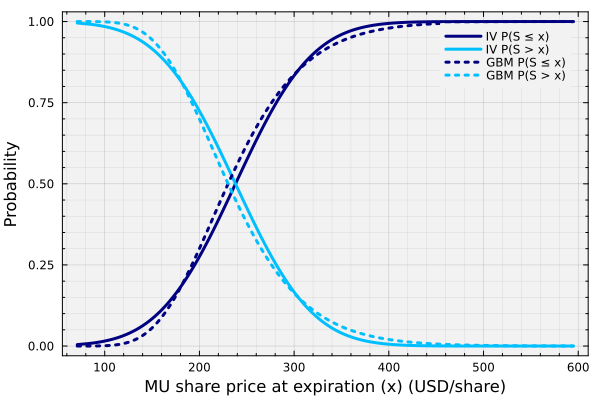

In [33]:
X = let
    number_of_samples = length(endpoint_samples);
    X = Array{Float64,2}(undef, number_of_samples, 3);
    S = Array{Float64,1}();
    for i ∈ eachindex(endpoint_samples)
        push!(S,endpoint_samples[i]);
    end
    S = sort(S);
    
    for i ∈ eachindex(S)
    
        X[i,1] = S[i];
        X[i,2] = cdf(d_gbm, S[i]);
        X[i,3] = cdf(d_IV, S[i]);
    end

    plot(X[:,1], X[:,3], lw=3, c=:navy, label="IV P(S ≤ x)", xminorticks=5, yminorticks=5, bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorgrid = true)
    plot!(X[:,1], 1 .- X[:,3], lw=3, c=:deepskyblue1, label="IV P(S > x)")

    plot!(X[:,1], X[:,2], lw=3, c=:navy, label="GBM P(S ≤ x)", xminorticks=5, yminorticks=5, ls=:dot)
    plot!(X[:,1], 1 .- X[:,2], lw=3, c=:deepskyblue1, label="GBM P(S > x)", ls=:dot)

    xlabel!("MU share price at expiration (x) (USD/share)", fontsize=18);
    ylabel!("Probability", fontsize=18);
end

In [34]:
do_I_see_the_CDF_plot = true; # set this value {true | false}

#### Scenario Analysis
Now that we have our cumulative distributions, we can compute the probability of observing various scenarios. Let's consider five scenarios.

> __Scenario 1: Probability of downside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _below_ the downside breakeven point $B^{-}$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}\leq{B^{-}} - \epsilon) = F_{S}\left(B^{-} - \epsilon\right)$.

We'll save the probability for this case in the `p_downside_loss_gbm::Float64` and `p_downside_loss_IV::Float64` variables:

In [35]:
p_downside_loss_gbm, p_downside_loss_IV = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_downside_loss_gbm = nothing;
    p_downside_loss_IV = nothing;

    # compute P(S < B_low -  ϵ) for the GBM and IV models
    p_downside_loss_gbm = cdf(d_gbm,B_low-ϵ);
    p_downside_loss_IV = cdf(d_IV,B_low-ϵ);

    # return data -
    p_downside_loss_gbm, p_downside_loss_IV
end;

In [36]:
println("Scenario 1: Probability of downside loss (GBM,IV) = ($(p_downside_loss_gbm),$(p_downside_loss_IV))")

Scenario 1: Probability of downside loss (GBM,IV) = (0.033664221783787376,0.06377904524912408)


Next, let's consider loss to the upside.
> __Scenario 2: Probability of upside loss__. In this scenario, the share price at expiration $S_{T}$ is at least $\epsilon$ _above_ the upside breakeven point $B^{+}$, assuming $\epsilon \geq $ `0.01` USD/share. The probability of this scenario occurring is given by $P(S_{T}>B^{+} + \epsilon) = 1 - F_{S}\left(B^{+} + \epsilon\right)$.

We'll save the probability for this case in the `p_upside_loss_gbm::Float64` and `p_upside_loss_IV::Float64` variables:

In [37]:
p_upside_loss_gbm, p_upside_loss_IV = let

    # initialize 
    ϵ = 0.01; # 1/100 USD
    p_upside_loss_gbm = nothing;
    p_upside_loss_IV = nothing;

    # compute P(S > B_high +  ϵ) for the GBM and IV models
    p_upside_loss_gbm = 1 - cdf(d_gbm,B_high+ϵ);
    p_upside_loss_IV = 1 - cdf(d_IV,B_high+ϵ);

    # return data -
    p_upside_loss_gbm, p_upside_loss_IV
end;

In [38]:
println("Scenario 2: Probability of upside loss (GBM,IV) = ($(p_upside_loss_gbm),$(p_upside_loss_IV))")

Scenario 2: Probability of upside loss (GBM,IV) = (0.1652067997641984,0.16913308586029863)


Next, consider the case where we receive the maximum profit.

> __Scenario 3: Maximum profit__. In this scenario, the share price at expiration $S_{T}$ is between the strike prices $K_{1}$ and $K_{2}$. The probability of this scenario occurring is given by $\mathbb{P}(K_{1} < S_{T} \leq{K_{2}}) = F_{S}\left(K_{2}\right) - F_{S}\left(K_{1} + \epsilon \right)$, assuming $\epsilon \geq $ `0.01` USD/share.

We'll save the probability for this case in the `p_max_profit_gbm::Float64` and `p_max_profit_IV::Float64` variables:

In [39]:
p_max_profit_gbm, p_max_profit_IV = let

    # initialize -
    ϵ = 0.01; # 1/100 USD
    p_max_profit_gbm = nothing;
    p_max_profit_IV = nothing;
    K₁ = put_contract_model.K;
    K₂ = call_contract_model.K;

    # compute the probability P(S_low < S_{T} ≤ S_high) for the GBM and IV
    p_max_profit_gbm = cdf(d_gbm,K₂) - cdf(d_gbm,K₁+ϵ);
    p_max_profit_IV = cdf(d_IV,K₂) - cdf(d_IV,K₁+ϵ);

    # return data -
    p_max_profit_gbm, p_max_profit_IV
end;

In [40]:
println("Scenario 3: Probability of maximum profit (GBM,IV) = ($(p_max_profit_gbm),$(p_max_profit_IV))")

Scenario 3: Probability of maximum profit (GBM,IV) = (0.7480012884993301,0.7072462388116857)


Now, let's compute the probability that the short put will be exercised (this gives us the chance that we'll need to purchase the `MU` shares at $K_{1}$ per share).

> __Scenario 4: Short put is exercised__. The short put contract will be exercised if the share price at expiration is `0.01` USD/share lower than the strike price. A back-of-the-envelope estimate of the probability of seeing this outcome is given by $\Delta$. How close is the $\Delta$ on the short put to the probability of exercise (POE) computed using the cumulative distribution function? This probability is given by: $\mathbb{P}(S_{T}\leq{(K_{1}-\epsilon)}) = F_{S}(K_{1}-\epsilon)$, assuming $\epsilon \geq $ `0.01` USD/share.

We'll save the probability for this case in the `p_short_put_exercised_gbm::Float64` and `p_short_put_exercised_IV::Float64` variables:

In [41]:
p_short_put_excercised_gbm, p_short_put_excercised_IV = let

    # initialize -
    ϵ = 0.01; # 1/100 USD
    p_max_profit_gbm = nothing;
    p_max_profit_IV = nothing;
    K₁ = put_contract_model.K;
    p_put_excercised_gbm = cdf(d_gbm, (K₁ - ϵ))
    p_put_excercised_IV = cdf(d_IV, (K₁ - ϵ))

    (p_put_excercised_gbm, p_put_excercised_IV)
end;

In [42]:
println("Scenario 4: Probability of short put exercised (GBM,IV) = ($(p_short_put_excercised_gbm),$(p_short_put_excercised_IV))")

Scenario 4: Probability of short put exercised (GBM,IV) = (0.055815370598640224,0.08413806240538649)


Finally, let's compute the probability that the short call is exercised. This is the likelihood that we'll need to sell shares at the strike price of the short call, which is $K_{2}$.

> __Scenario 5: Short call is exercised__. The short call contract will be exercised if the share price at expiration is `0.01` USD/share higher than the strike price. A back-of-the-envelope estimate of the probability of seeing this outcome is given by $\Delta$ of the call contract. How close is the $\Delta$ on the short call to the probability of exercise (POE) computed using the cumulative distribution function? This probability is given by: $\mathbb{P}(S_{T}\geq{(K_{2}+\epsilon)}) = 1 - F_{S}(K_{2}+\epsilon)$, assuming $\epsilon \geq $ `0.01` USD/share.

We'll save the probability for this case in the `p_short_call_exercised_gbm::Float64` and `p_short_call_exercised_IV::Float64` variables:

In [43]:
p_short_call_excercised_gbm, p_short_call_excercised_IV = let

    # initialize -
    ϵ = 0.01; # 1/100 USD
    K₂ = call_contract_model.K;
    p_call_excercised_gbm = 1 - cdf(d_gbm, (K₂ + ϵ))
    p_call_excercised_IV = 1 - cdf(d_IV, (K₂ + ϵ))

    (p_call_excercised_gbm, p_call_excercised_IV)
end;

In [44]:
println("Scenario 5: Probability of short call exercised (GBM,IV) = ($(p_short_call_excercised_gbm),$(p_short_call_excercised_IV))")

Scenario 5: Probability of short call exercised (GBM,IV) = (0.1960922407587986,0.2085225191922202)


#### Outcome Summary
`Unhide` the code block below to see how we developed a table displaying the probability of profit calculations for an `MU` put option using the risk-neutral geometric Brownian motion `d_gbm` and IV-based price distributions `d_IV`. 

> __Summary__: The table below compares probability estimates for various outcome scenarios using two different models: `GBM` (geometric Brownian motion with log-normal distribution) and `IV` (implied volatility-based normal distribution). Columns `Sₒ`, `σ`, and `DTE` show the current share price (USD/share), average implied volatility (decimal), and days to expiration. Columns `put_K₁`, `call_K₂`, `width`, and `max_profit` display the strike prices, strangle width $K_{2} - K_{1}$, and maximum profit potential (all in USD/share). The probability columns show: `p_max_profit` (share price between strikes), `p_downside_loss` (share price below $B^{-}$), `p_upside_loss` (share price above $B^{+}$), and `p_other`, representing intermediate profit/loss regions between strikes and breakeven points.

So what do we see in the table below?

In [45]:
let 
    
    # initialize -
    table_df = DataFrame()
    ϵ = 0.01;
    σ̄ = (1/2)*(call_leg_data[:IV] + put_leg_data[:IV]);

    # GBM row -
    gbm_row = (
        model="GBM",
        Sₒ = Sₒ,
        σ = σ̄,
        DTE = DTE,
        put_K₁ = put_contract_model.K,
        call_K₂ = call_contract_model.K,
        width = call_contract_model.K - put_contract_model.K,
        max_profit = (call_contract_model.premium + put_contract_model.premium),
        p_max_profit = p_max_profit_gbm,
        p_downside_loss = p_downside_loss_gbm,
        p_upside_loss = p_upside_loss_gbm,
        p_other = 1 - (p_max_profit_gbm + p_downside_loss_gbm + p_upside_loss_gbm)
    );
    push!(table_df, gbm_row);

    # IV row -
    IV_row = (
        model="IV",
        Sₒ = Sₒ,
        σ = σ̄,
        DTE = DTE,
        put_K₁ = put_contract_model.K,
        call_K₂ = call_contract_model.K,
        width = call_contract_model.K - put_contract_model.K,
        max_profit = (call_contract_model.premium + put_contract_model.premium),
        p_max_profit = p_max_profit_IV,
        p_downside_loss = p_downside_loss_IV,
        p_upside_loss = p_upside_loss_IV,
        p_other = 1 - (p_max_profit_IV + p_downside_loss_IV + p_upside_loss_IV)
    );
    push!(table_df, IV_row);
    
    # make a table -
    pretty_table(
            table_df;
            fit_table_in_display_horizontally = false,
            backend = :text,
            table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- --------- --------- --------- --------- --------- --------- ------------ -------------- ----------------- --------------- -----------
   model        Sₒ         σ       DTE    put_K₁   call_K₂     width   max_profit   p_max_profit   p_downside_loss   p_upside_loss     p_other 
  String   Float64   Float64   Float64   Float64   Float64   Float64      Float64        Float64           Float64         Float64     Float64 
 -------- --------- --------- --------- --------- --------- --------- ------------ -------------- ----------------- --------------- -----------
     GBM    237.02    0.8051      41.0     150.0     290.0     140.0         9.34       0.748001         0.0336642        0.165207   0.0531277
      IV    237.02    0.8051      41.0     150.0     290.0     140.0         9.34       0.707246          0.063779        0.169133   0.0598416
 -------- --------- --------- --------- --------- --------- --------- ------------ -------------- ----------------- --------------- ------

In [46]:
do_I_see_the_POP_table = true; # set this value {true | false}

## Discussion Questions
Now that our calculations are complete, consider the following questions about the short strangle strategy in the context of an earnings announcement trade.

### Question 1
Examine the relationship between the strangle width (the difference between your call and put strike prices) and the maximum profit potential. 
* __Q1:__ How does selecting strikes that are closer together versus farther apart affect both the premium collected and the range of share prices at expiration where you achieve maximum profit? Based on your analysis, explain which configuration might be more appropriate for a high-conviction earnings trade where you expect minimal price movement.

__Answer Question 1:__ Fill me in.

In [47]:
did_I_answer_question_1 = true; # set this value {true | false}

### Question 2
The portfolio delta $\Delta_{p}$ shown at the end of Task 2 provides insight into the directional exposure of your short strangle position. Using the table from Task 2, analyze the portfolio delta value and compare it to the individual delta values of the put and call legs. 
* __Q2:__ What does the sign and magnitude of $\Delta_{p}$ reveal about the position's sensitivity to small changes in the underlying share price? Consider a scenario where Micron announces earnings and the stock moves upward by a small amount the next morning. Would your position initially gain or lose value based on the portfolio delta, and how does this relate to the broader risk profile of the strangle as shown in the profit diagram?

__Answer Question 2:__ Fill me in.

In [48]:
did_I_answer_question_2 = true; # set this value {true | false}

### Question 3
Both the geometric Brownian motion and implied volatility models in Task 3 use the same average implied volatility $\bar{\sigma}$ from the option contracts. However, the GBM model produces a log-normal distribution (right-skewed, cannot be negative), while the IV model produces a normal distribution (symmetric, can theoretically be negative). 

* __Q3:__ Using the probability table at the end of Task 3, compare the `p_max_profit`, `p_downside_loss`, and `p_upside_loss` values between the two models. What do these differences reveal about how distribution shape affects your earnings trade assessment? Which model would you rely on more when deciding whether to enter this short strangle, and why?

__Answer Question 3:__ Fill me in.

In [49]:
did_I_answer_question_3 = true; # set this value {true | false}

___

## Summary
We demonstrated how to construct and analyze a short strangle options strategy using real market data, combining analytical calculations with probabilistic modeling to assess risk and potential outcomes.

> __Key Takeaways:__
> 
> * The short strangle profit diagram exhibits a characteristic profile with maximum profit occurring when the share price at expiration falls between the two strike prices, and losses occurring when the share price moves significantly beyond either breakeven point.
> * Breakeven points for a short strangle are calculated analytically, where the lower breakeven equals the put strike price minus the total premiums collected from both legs, and the upper breakeven equals the call strike price plus the total premiums collected from both legs, defining the boundaries between profitable and unprofitable regions at expiration.
> * The cumulative distribution function enables quantitative probability estimates for different outcome scenarios, with the geometric Brownian motion model producing a log-normal distribution and the implied volatility model producing a normal distribution, each offering different perspectives on future price ranges and associated probabilities.

This approach shows how options contracts can be combined to create positions with specific risk-reward profiles, and how probabilistic models provide forward-looking estimates of strategy performance under different market conditions.
___

## Tests
In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [50]:
let 
    @testset verbose = true "CHEME 5660 problem set 5 test suite" begin

        @testset "Task 1: Call and Put contract data" begin
            @test @isdefined(put_contracts)
            @test @isdefined(call_contracts)
            @test !isempty(put_contracts)
            @test !isempty(call_contracts)
            @test @isdefined(call_leg_data)
            @test @isdefined(put_leg_data)
        end

        @testset "Task 2: Build Contract models, profit diagram and breakeven" begin
            @test @isdefined(put_contract_model)
            @test @isdefined(call_contract_model)
            @test isa(put_contract_model, MyAmericanPutContractModel)
            @test isa(call_contract_model, MyAmericanCallContractModel)
            @test @isdefined(future_share_price_array)
            @test !isempty(future_share_price_array)
            @test @isdefined(profit_array)
            @test !isempty(profit_array)
            @test @isdefined(B_low)
            @test @isdefined(B_high)
            @test isa(B_low, Number)
            @test isa(B_high, Number)
            @test B_low < B_high
            @test do_I_see_the_profit_loss_plot == true
        end

        @testset "Task 3: POP calculations" begin
            @test @isdefined(gbm_model)
            @test @isdefined(σ̄)
            @test isa(gbm_model, MyGeometricBrownianMotionEquityModel)
            @test isa(σ̄, Number)
            @test σ̄ > 0
            @test @isdefined(endpoint_samples)
            @test !isempty(endpoint_samples)
            @test @isdefined(d_gbm)
            @test @isdefined(d_IV)
            @test do_I_see_the_share_price_plot == true
            @test do_I_see_the_CDF_plot == true
            @test @isdefined(X)
            @test !isempty(X)
            @test do_I_see_the_POP_table == true
            @test @isdefined(p_downside_loss_gbm)
            @test @isdefined(p_downside_loss_IV)
            @test @isdefined(p_upside_loss_gbm)
            @test @isdefined(p_upside_loss_IV)
            @test @isdefined(p_max_profit_gbm)
            @test @isdefined(p_max_profit_IV)
            @test isa(p_downside_loss_gbm, Number)
            @test isa(p_downside_loss_IV, Number)
            @test isa(p_upside_loss_gbm, Number)
            @test isa(p_upside_loss_IV, Number)
            @test isa(p_max_profit_gbm, Number)
            @test isa(p_max_profit_IV, Number)
            @test 0 ≤ p_downside_loss_gbm ≤ 1
            @test 0 ≤ p_downside_loss_IV ≤ 1
            @test 0 ≤ p_upside_loss_gbm ≤ 1
            @test 0 ≤ p_upside_loss_IV ≤ 1
            @test 0 ≤ p_max_profit_gbm ≤ 1
            @test 0 ≤ p_max_profit_IV ≤ 1
        end 

        @testset "Questions" begin
            @test did_I_answer_question_1 == true
            @test did_I_answer_question_2 == true
            @test did_I_answer_question_3 == true
        end
    end
end;

Test Summary:                                                 | Pass  Total  Time
CHEME 5660 problem set 5 test suite                           |   55     55  0.5s
  Task 1: Call and Put contract data                          |    6      6  0.4s
  Task 2: Build Contract models, profit diagram and breakeven |   14     14  0.0s
  Task 3: POP calculations                                    |   32     32  0.0s
  Questions                                                   |    3      3  0.0s


## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.